# Imports

In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading Dataset

Extracting the .zip file provided by Kaggle and making a dictionary that stores the training, testing and submission set.

In [2]:
! kaggle competitions download -c titanic

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
zip_file = ZipFile('titanic.zip')

In [4]:
dfs = {csv_file.filename.split('.')[0] : pd.read_csv(zip_file.open(csv_file.filename)) for csv_file in zip_file.infolist()}

In [5]:
dfs["train"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
dfs["test"]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [7]:
all_df = pd.concat([dfs["train"], dfs["test"]], sort=True).reset_index(drop=True)

# Cleaning Dataset

## Missing Values

In [8]:
for name in ["train", "test"]:
    print(f"{name}ing set:")
    for col in dfs[name].columns:
        if(dfs[name][col].isnull().any()):
            print(f"Missing {col}: {dfs[name][col].isnull().sum()}")
    print()

training set:
Missing Age: 177
Missing Cabin: 687
Missing Embarked: 2

testing set:
Missing Age: 86
Missing Fare: 1
Missing Cabin: 327



### Age

Filling out missing values for age is usually done by the median of ages in the dataset. To be a bit more precise I used information that correlated with the age of the person, that being the Passenger Class. So I calculated the median age of these groups and filled out the NaN cells with the correct value.

<AxesSubplot:>

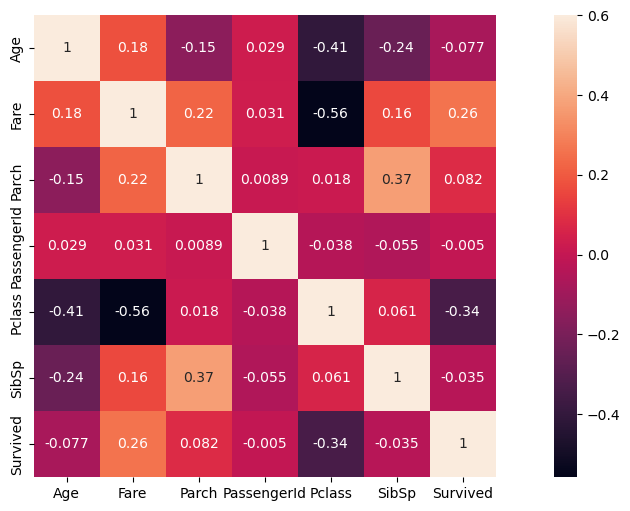

In [9]:
plt.figure(figsize=(15,6))
sns.heatmap(all_df.corr(), vmax=0.6, square=True, annot=True)

In [10]:
all_df.groupby(["Pclass"])["Age"].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,284.0,39.159930,14.548028,0.92,28.0,39.0,50.0,80.0
2,261.0,29.506705,13.638627,0.67,22.0,29.0,36.0,70.0
3,501.0,24.816367,11.958202,0.17,18.0,24.0,32.0,74.0


In [11]:
all_df["Age"] = all_df.groupby(["Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))

### Fare

Next up I filled out the one missing Fare cell. This was done by looking up the row that had the missing value and calculated the median of the fare data given information about that person.

In [12]:
all_df[all_df["Fare"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [13]:
all_df["Fare"].fillna(value=all_df["Fare"][(all_df["Sex"] == "male") & (all_df["Pclass"] == 3)].median(), inplace=True)

### Emarked

Fixing the Embarked cells now. Looking at the rows that contain the missing values we can deduce that the 2 people have similar informations. So I choose the most frequent embarking location that was used by the people with those features. This doesn't neccesseraly mean that the 2 people indeed embarked at those locations.

In [14]:
all_df[all_df["Embarked"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [15]:
all_df["Embarked"].fillna(
    value=all_df["Embarked"][(all_df["Sex"] == "female") & (all_df["Pclass"] == 1)].mode()[0],
    inplace=True)

### Cabin

The last feature that has missing values is "Cabin". I replaced all the NaN values with "M" referring to missing. Trying to fill in missing values to existing cabins would just mess up the feature. Since "M" is now a lot more frequent than any other cabin data, I made some abstraction to the rest of the data by removing the cabin number and leaving only the deck character.

In [16]:
all_df[all_df["Cabin"].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,24.0,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
...,...,...,...,...,...,...,...,...,...,...,...,...
1303,28.0,NaN,S,7.7750,"Henriksson, Miss. Jenny Lovisa",0,1304,3,female,0,NaN,347086
1304,24.0,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262
1307,24.0,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309


In [17]:
all_df["Cabin"].fillna(value="M", inplace=True)

In [18]:
all_df["Cabin"] = all_df["Cabin"].apply(lambda x : x[0])

In [19]:
all_df["Cabin"].value_counts()

M    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

## New Features

### Name

After filling out every missing value we still have features that should be examined. The Name feature would not help us in it's current state, so we need to abstract it. Extracting the title form each name could be helpful.

In [20]:
all_df['Title'] = all_df['Name'].str.extract(' ([A-Za-z]+)\.')

In [21]:
all_df.groupby(['Title'])['Title'].count().sort_values(ascending=False)

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
Mme           1
Capt          1
Lady          1
Jonkheer      1
Dona          1
Don           1
Countess      1
Sir           1
Name: Title, dtype: int64

In [22]:
all_df['Title'] = all_df['Title'].replace([title for title in all_df['Title'] if title not in ['Mr', 'Mrs', 'Miss', 'Master']], 'Other')

In [23]:
all_df.groupby(['Title'])['Title'].count().sort_values(ascending=False)

Title
Mr        757
Miss      260
Mrs       197
Master     61
Other      34
Name: Title, dtype: int64

### SibSp, Parch

Let's take a look at family size. We can determine one person's family size with the help of SibSp and the Parch feature. I examined the people that are travelling alone and they have a lower chance of survival, so I added the new feature to the dataset.

In [24]:
all_df['IsAlone'] = 0
all_df.loc[(all_df['SibSp'] +  all_df['Parch'] + 1) == 1, 'IsAlone'] = 1

In [25]:
all_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


We have some features that are not valuable in terms of predicting the outcome. I'm referring to Ticket and PassengerId. Removing these features will help with predicting the correct outcome.

In [26]:
all_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)

## One Hot Encoding

We are going to use One Hot Encoding on categorical features such as Cabin, Embarked, Sex, Pclass, Title.

In [27]:
all_df = pd.get_dummies(all_df, columns=['Cabin', 'Embarked', 'Sex', 'Pclass', 'Title'], drop_first=True)

In [28]:
all_df

,Age,Fare,Survived,IsAlone,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,...,Cabin_T,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,22.0,7.2500,0.0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
1,38.0,71.2833,1.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,26.0,7.9250,1.0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
3,35.0,53.1000,1.0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,35.0,8.0500,0.0,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,24.0,8.0500,NaN,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
1305,39.0,108.9000,NaN,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1306,38.5,7.2500,NaN,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
1307,24.0,8.0500,NaN,1,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0


After cleaning and preparing the data for learning, we split the dataset once again.

In [29]:
dfs = {"train" : all_df.loc[:890], "test" : all_df.loc[891:].drop(['Survived'], axis=1), "submission" : dfs["gender_submission"]}

In [30]:
x_train = dfs["train"].loc[:, dfs["train"].columns != "Survived"]
y_train = dfs["train"].Survived.astype(int)
x_test = dfs["test"]

## Scaling Features

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
x_train.loc[:, ["Age", "Fare"]] = StandardScaler().fit_transform(x_train.loc[:, ["Age", "Fare"]])
x_test.loc[:, ["Age", "Fare"]] = StandardScaler().fit_transform(x_test.loc[:, ["Age", "Fare"]])

C:\Users\nyist\AppData\Local\Temp\ipykernel_19692\225576572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train.loc[:, ["Age", "Fare"]] = StandardScaler().fit_transform(x_train.loc[:, ["Age", "Fare"]])


In [33]:
x_train

,Age,Fare,IsAlone,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_Q,Embarked_S,Sex_male,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,-0.537087,-0.502445,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0
1,0.667524,0.786845,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,-0.235934,-0.488854,1,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0
3,0.441659,0.420730,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,0.441659,-0.486337,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,-0.160646,-0.386671,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,1
887,-0.762952,-0.044381,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
888,-0.386511,-0.176263,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0
889,-0.235934,-0.044381,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
model = LogisticRegression()

model.fit(x_train, y_train)
preds = model.predict(x_test)

In [36]:
model.score(x_train, y_train)

0.8305274971941639

In [37]:
dfs["submission"].Survived = preds.astype(int)
dfs["submission"].to_csv('regression_submission.csv', index=False)

The submission got an score of 0.770

# Neural Network

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback, TensorBoard, EarlyStopping

In [39]:
early_stopping = EarlyStopping(patience=15, monitor="val_accuracy", verbose=1)
tensorboard_callback = TensorBoard(log_dir="./logs/classification_model", write_graph=True, histogram_freq=1)

In [40]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=x_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,633
Trainable params: 13,633
Non-trainable params: 0
_________________________________________________________________


In [41]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping, tensorboard_callback])

Epoch 1/100
 1/23 [>.............................] - ETA: 0s - loss: 0.6628 - accuracy: 0.7188WARNING:tensorflow:From C:\Users\nyist\miniconda3\envs\summ\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
23/23 [==============================] - 1s 41ms/step - loss: 0.5713 - accuracy: 0.7430 - val_loss: 0.4506 - val_accuracy: 0.8436
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4722 - accuracy: 0.7963 - val_loss: 0.3949 - val_accuracy: 0.8380
Epoch 3/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4478 - accuracy: 0.8048 - val_loss: 0.3876 - val_accuracy: 0.8268
Epoch 4/100
23/23 [==============================] - 0s 7ms/step - loss: 0.4348 - accuracy: 0.8160 - val_loss: 0.3747 - val_accuracy: 0.8659
Epoch 5/100
23/23 [==============================] - 0s 7ms/

In [42]:
preds = model.predict(x_test) > 0.5

In [43]:
dfs["submission"].Survived = preds.astype(int)
dfs["submission"].to_csv('binary_classification_submission.csv', index=False)

The submission got a score of 0.763

# Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
model = RandomForestClassifier(n_estimators=100)

model.fit(x_train, y_train)
preds = model.predict(x_test)

In [46]:
model.score(x_train, y_train)

0.9876543209876543

In [47]:
dfs["submission"].Survived = preds.astype(int)
dfs["submission"].to_csv('randomforest_submission.csv', index=False)

The submission got a score of 0.787

#### The best score I could achieve is 78.7%, which is in the top 10% regarding the competition.

# Evaluation

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
confusion_matrix_preds = model.predict(x_train)

In [50]:
labels = ['Positive', 'Negative']
confusion_matrix = confusion_matrix(y_train, confusion_matrix_preds.astype(int))
df_confusion_matrix = pd.DataFrame(confusion_matrix, index = labels, columns = labels)

<AxesSubplot:>

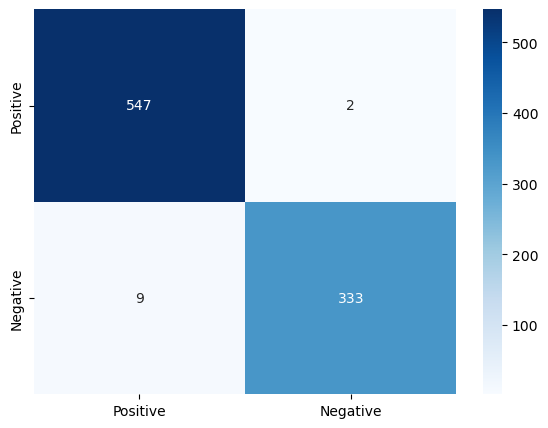

In [51]:
plt.figure(figsize = (15,5))
plt.subplot(121)
sns.heatmap(df_confusion_matrix, annot=True, fmt='d', cmap = "Blues")

In [52]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir "./logs/classification_model"